In [1]:
import sys
print(sys.executable)
#Installing specific venv
# /workspaces/Azure-Cost-optimization/.venv/bin/python -m pip install pandas

/workspaces/Azure-Cost-optimization/.venv/bin/python


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from lifetimes import utils as lifetimes_utils

# --- Configuration for Simulation ---
N_CUSTOMERS = 4000  # Target number of unique high-value patrons
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2025, 12, 31)
N_DAYS = (END_DATE - START_DATE).days

# --- PHASE A: Simulate Raw Transaction Log (Step A1 - A3) ---
print("1. Simulating Raw Transaction Log...")

# 1. Generate Customer IDs
customer_ids = np.array([f'MGM_{i:04d}' for i in range(1, N_CUSTOMERS + 1)])

# 2. Simulate Transaction Frequency and Volume
# We aim for ~100,000 transactions total (avg 25 per customer)
N_TRANSACTIONS = 100000

# Randomly select customers, giving a slight edge to some to simulate 'High-Value' concentration
simulated_customer_ids = np.random.choice(customer_ids, size=N_TRANSACTIONS, p=None)

# 3. Simulate Transaction Dates
# Randomly select a day within the 24-month period
transaction_days = np.random.randint(0, N_DAYS, size=N_TRANSACTIONS)
transaction_dates = [START_DATE + timedelta(days=int(d)) for d in transaction_days]

# 4. Simulate Net Revenue (Skewed to simulate high-value patrons)
# Use a Gamma distribution to simulate high skew (many small values, few large ones)
# Mean transaction value is set high to reflect 'High-Value Patrons' (e.g., $400)
revenue_shape = 2.0
revenue_scale = 200
net_revenue = np.random.gamma(revenue_shape, revenue_scale, N_TRANSACTIONS)
# Ensure all revenue is positive
net_revenue = np.maximum(net_revenue, 5.0)

# 5. Simulate Contextual Features
channels = np.random.choice(['Gaming', 'Hotel', 'Dining', 'Retail'], size=N_TRANSACTIONS, p=[0.4, 0.3, 0.2, 0.1])
promotion_indicator = np.random.randint(0, 2, size=N_TRANSACTIONS) # 0 or 1

# Create the final DataFrame
raw_transactions_df = pd.DataFrame({
    'Customer_ID': simulated_customer_ids,
    'Transaction_Date': transaction_dates,
    'Net_Revenue': net_revenue.round(2),
    'Channel': channels,
    'Promotion_Indicator': promotion_indicator
})

# Sort by customer and date for realism
raw_transactions_df.sort_values(by=['Customer_ID', 'Transaction_Date'], inplace=True)
raw_transactions_df.reset_index(drop=True, inplace=True)

print(f"   -> Raw Transactions simulated: {len(raw_transactions_df):,} rows.")
print(raw_transactions_df.head())
print("-" * 50)


# --- PHASE B: Feature Engineering (Steps B4 & B5) ---
print("2. Generating RFM Summary Table (Feature Engineering)...")

# 1. Define Training and Prediction Periods
# T_CALIBRATION is the split date: 2024-12-31
T_CALIBRATION = datetime(2024, 12, 31)

# 2. Calculate RFM Features (Training Set) - Step B4
# Use the 'lifetimes' utility to transform transaction data into the required RFM summary
# T (Age) and Recency (t_x) are calculated relative to the T_CALIBRATION date.
rfm_df_raw = lifetimes_utils.summary_data_from_transaction_data(
    raw_transactions_df,
    customer_id_col='Customer_ID',
    datetime_col='Transaction_Date',
    monetary_value_col='Net_Revenue',
    # Calculate RFM only based on data *before* the split date
    observation_period_end=T_CALIBRATION,
    freq='D' # Calculate Recency/T in days
)

# Rename columns to the standard BG/NBD notation for clarity
rfm_df = rfm_df_raw.rename(columns={
    'frequency': 'x',         # Frequency
    'recency': 't_x',         # Recency (age of last purchase)
    'T': 'T',                 # Customer Age
    'monetary_value': 'm'     # Average Monetary Value (Monetary)
})

# 3. Define Target Variable (Actual CLV) - Step B5
# Identify transactions that occurred *after* the calibration date (the 12-month prediction period)
prediction_period_txns = raw_transactions_df[raw_transactions_df['Transaction_Date'] > T_CALIBRATION].copy()

# Sum the revenue in the prediction period for each customer
target_clv_df = prediction_period_txns.groupby('Customer_ID')['Net_Revenue'].sum().reset_index()
target_clv_df.rename(columns={'Net_Revenue': 'Actual_12m_CLV'}, inplace=True)

# Merge the target CLV back into the RFM summary table
rfm_df = rfm_df.merge(target_clv_df, on='Customer_ID', how='left').fillna(0)


# --- FINAL DATASET READY FOR MODEL TRAINING ---
print(f"   -> RFM Summary Table generated: {len(rfm_df):,} customers.")
print("\nFinal Dataset (Input for CLV Models):")
# Filter out customers with 0 frequency (no repeat purchase, cannot train Gamma-Gamma)
# Also filter out customers who never transacted in the training period (T=0)
rfm_df = rfm_df[(rfm_df['x'] > 0) & (rfm_df['T'] > 0)]

print(f"   -> Customers ready for modeling (x > 0 and T > 0): {len(rfm_df):,} customers.")
print(rfm_df.describe().T[['count', 'mean', 'std', 'min', 'max']])

# Save the RFM table to CSV for further use in Phase C
rfm_df.to_csv('clv_rfm_summary_data.csv', index=True)
print("\nRFM data saved to 'clv_rfm_summary_data.csv'")

1. Simulating Raw Transaction Log...
   -> Raw Transactions simulated: 100,000 rows.
  Customer_ID Transaction_Date  Net_Revenue Channel  Promotion_Indicator
0    MGM_0001       2024-02-07       395.60  Dining                    0
1    MGM_0001       2024-02-20       995.35   Hotel                    0
2    MGM_0001       2024-03-28       499.43   Hotel                    0
3    MGM_0001       2024-04-20       433.40  Gaming                    1
4    MGM_0001       2024-06-23       715.18  Gaming                    0
--------------------------------------------------
2. Generating RFM Summary Table (Feature Engineering)...
   -> RFM Summary Table generated: 4,000 customers.

Final Dataset (Input for CLV Models):
   -> Customers ready for modeling (x > 0 and T > 0): 4,000 customers.
                 count         mean          std     min           max
x               4000.0    11.257750     3.464291    2.00     24.000000
t_x             4000.0   307.918500    41.353191   20.00    365.0

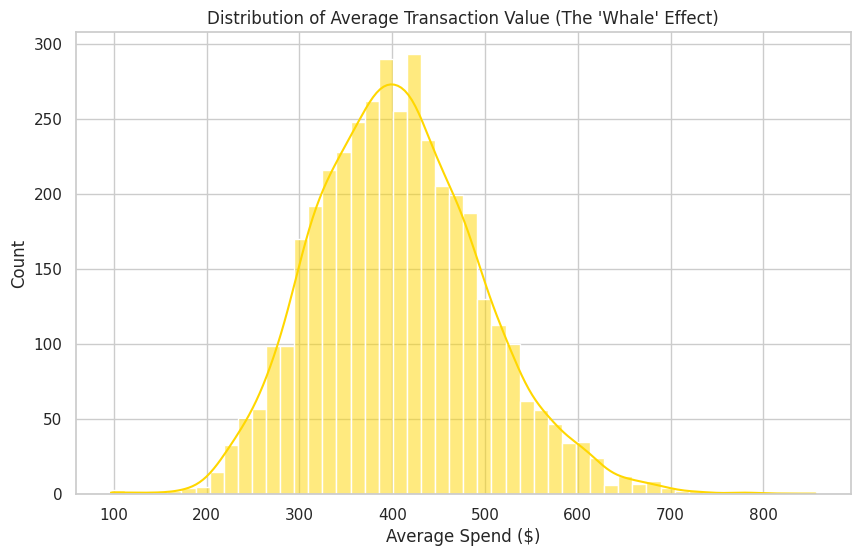

<Figure size 1000x800 with 0 Axes>

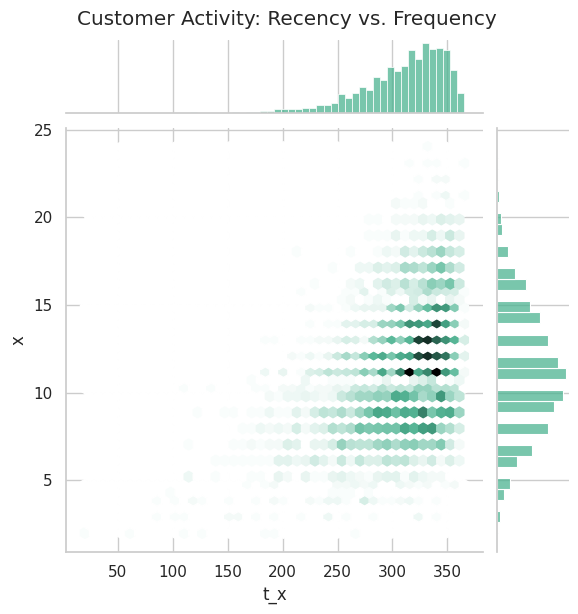

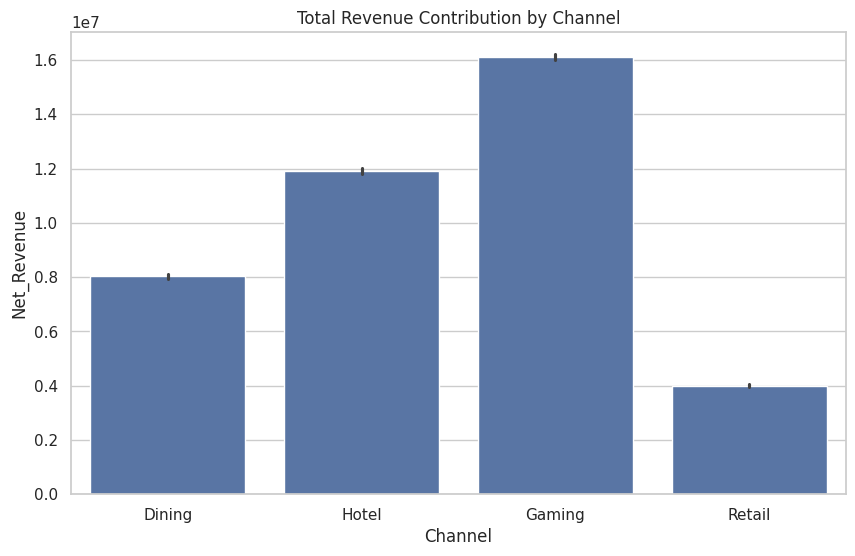

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style
sns.set_theme(style="whitegrid")

# 1. Show the Skew (The "Whale" Effect)
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['m'], bins=50, kde=True, color='gold')
plt.title("Distribution of Average Transaction Value (The 'Whale' Effect)")
plt.xlabel("Average Spend ($)")
plt.show()

# 2. Recency vs. Frequency Heatmap
plt.figure(figsize=(10, 8))
sns.jointplot(data=rfm_df, x='t_x', y='x', kind="hex", color="#4CB391")
plt.suptitle("Customer Activity: Recency vs. Frequency", y=1.02)
plt.show()

# 3. Channel Split (Using the raw data)
plt.figure(figsize=(10, 6))
sns.barplot(data=raw_transactions_df, x='Channel', y='Net_Revenue', estimator=sum)
plt.title("Total Revenue Contribution by Channel")
plt.show()

In [4]:
from lifetimes import BetaGeoFitter

# 1. Fit the BG/NBD model to your RFM data
# Penalizer_coef helps prevent overfitting if some customers have extreme values
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm_df['x'], rfm_df['t_x'], rfm_df['T'])

# 2. Calculate the "Probability of Being Alive" (the Churn Risk inverse)
rfm_df['p_alive'] = bgf.conditional_probability_alive(
    rfm_df['x'], 
    rfm_df['t_x'], 
    rfm_df['T']
)

# 3. Predict expected transactions for the next 365 days
rfm_df['exp_purchases_1yr'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    365, rfm_df['x'], rfm_df['t_x'], rfm_df['T']
)

print(rfm_df[['x', 't_x', 'T', 'p_alive', 'exp_purchases_1yr']].head())

      x    t_x      T  p_alive  exp_purchases_1yr
0   8.0  310.0  328.0      1.0           9.753239
1  10.0  342.0  356.0      1.0          10.726009
2  17.0  300.0  353.0      1.0          16.269576
3  12.0  274.0  345.0      1.0          12.574685
4  10.0  281.0  338.0      1.0          11.153436


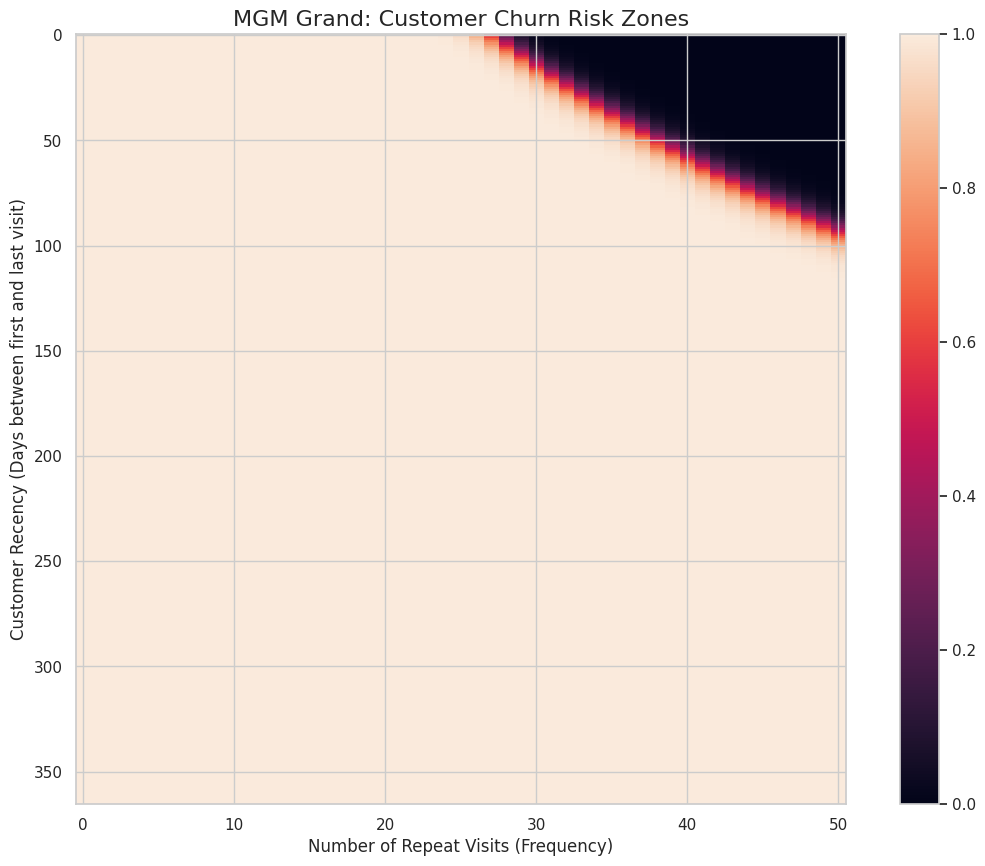

In [5]:
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_probability_alive_matrix

# 1. Create your figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# 2. Set the 'current active axis' to your specific ax
plt.sca(ax) 

# 3. Call the function WITHOUT the ax=ax argument
plot_probability_alive_matrix(
    bgf, 
    max_frequency=50, 
    max_recency=365
)

# 4. Final touches
ax.set_title("MGM Grand: Customer Churn Risk Zones", fontsize=16)
ax.set_xlabel("Number of Repeat Visits (Frequency)", fontsize=12)
ax.set_ylabel("Customer Recency (Days between first and last visit)", fontsize=12)

plt.show()

In [6]:
from lifetimes import GammaGammaFitter

# 1. The Gamma-Gamma model has a strict requirement: 
# It only works on 'Repeat' customers (Frequency > 0) 
# and requires Monetary Value > 0. You already filtered this in Phase B!

# 2. Fit the Model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm_df['x'], rfm_df['m'])

# 3. Calculate 'Conditional Expected Average Profit'
# This is the "True Spend Potential" per visit, smoothing out one-time spikes
rfm_df['expected_avg_spend'] = ggf.conditional_expected_average_profit(
    rfm_df['x'],
    rfm_df['m']
)

# 4. Calculate the FINAL Predicted 12-Month CLV
# This combines BG/NBD (Probability/Frequency) with Gamma-Gamma (Monetary)
rfm_df['predicted_clv_12m'] = ggf.customer_lifetime_value(
    bgf, # Your BG/NBD model
    rfm_df['x'],
    rfm_df['t_x'],
    rfm_df['T'],
    rfm_df['m'],
    time=12, # 12 months forecast
    discount_rate=0.01 # Monthly discount rate
)

print(rfm_df[['Customer_ID', 'm', 'expected_avg_spend', 'predicted_clv_12m']].head())

  Customer_ID           m  expected_avg_spend  predicted_clv_12m
0    MGM_0001  545.271250          558.621647        5040.150566
1    MGM_0002  399.116000          406.998118        4038.382439
2    MGM_0003  417.099412          421.897699        6349.803300
3    MGM_0004  337.548333          343.134602        3991.521859
4    MGM_0005  410.462000          418.557444        4318.576476


In [7]:
# Check the correlation between Frequency (x) and Monetary (m)
correlation = rfm_df[['x', 'm']].corr()
print(f"Correlation between Frequency and Monetary: {correlation.iloc[0,1]:.2f}")
# Ideally, this should be close to 0 (e.g., -0.1 to 0.1)

Correlation between Frequency and Monetary: 0.02
